In [1]:
!pip install biopython
!pip install transformers

     |████████████████████████████████| 2.3MB 4.9MB/s 
     |████████████████████████████████| 368kB 4.9MB/s 
     |████████████████████████████████| 645kB 57.0MB/s 
     |████████████████████████████████| 860kB 51.2MB/s 
     |████████████████████████████████| 1.0MB 50.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=a8cd5b11c8f7f061fab4fe3c9e14aa3ddd6c0b0dbfbe9bc3235f0d3afea103d5
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [0]:
import os
import gzip
import pickle
import numpy as np
from Bio import SeqIO
from Bio.Data import CodonTable
from matplotlib import pyplot as plt

import torch

from transformers import GPT2Config, GPT2Model, GPT2LMHeadModel

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def check_known_protein(protein_description):
    """filter out hypothetical and putative proteins"""
    is_hypothetical = ('hypoth' in protein_description or 'hetical' in protein_description) # deals with most common misspellings of "hypothetical"
    is_putative = 'putative' in protein_description
    is_known = (not is_hypothetical) and (not is_putative)
    return is_known

def get_CDS_locations(genome_path):
    """exctracts gene locations and seqs from known protein coding genes, only non-hypothetical"""
    gene_loc_list = []
    gene_seq_list = []
    with gzip.open(genome_path, 'rt') as handle: # open file
        for record in SeqIO.parse(handle, "genbank"): # parse each record within file
            feature_list = record.features
            CDS_list = [x for x in feature_list if x.type=='CDS'] # get all CDS features in record
            for CDS in CDS_list:
                try:
                    protein_description = CDS.qualifiers['product'][0]
                    if check_known_protein(protein_description): # only use non-hypothetical proteins
                        gene_loc = CDS.location
                        gene_loc_list.append(gene_loc)

                        gene_seq = CDS.extract(record.seq) # extract locations of CDS
                        gene_seq_list.append(gene_seq)
                except:
                    pass

    return gene_loc_list, gene_seq_list

In [9]:
# all code needed to produce score for "geneness" of amino acid sequence

# mount
from google.colab import drive
drive.mount('/content/drive')
# modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models"
modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models/10-25-19_morning_20"

# load model
model = GPT2LMHeadModel.from_pretrained(modeldir).to('cuda')

# score sequence
def score_seq(aa_seq_string):
    aa_seq_string = aa_seq_string[:40] ################### TODO implement shingles
    
    token = tokenize_aa_seq(aa_seq_string)
    input_ids = token.unsqueeze(0).to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    predval = torch.roll(torch.argmax(softproportion, axis=2), 1) # remember prediction offset by 1
    
    correctmask = predval == input_ids[:] # why no offset here?
    hardcorrect = torch.sum(correctmask).item()
    totalcorrect = logits.shape[0]*logits.shape[1]

    softcorrect = 0
    for i in range(input_ids.shape[0]):
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            softcorrect += softproportion[i, j, input_ids[i,j+1]]
    # softcorrect = softcorrect.item()
    softcorrect = softcorrect


    softproportion = softcorrect/totalcorrect 
    hardproportion = hardcorrect/totalcorrect

    return softproportion # hard proportion might work better on long sequences

def tokenize_aa_seq(aa_seq):
    """Convert amino acid letters to integers. Can also use murphy's reduced aa alphabet later"""
    table = {"L":1,
             "V":2,
             "I":3,
             "M":4,
             "C":5,
             "A":6,
             "G":7,
             "S":8,
             "T":9,
             "P":10,
             "F":11,
             "Y":12,
             "W":13,
             "E":14,
             "D":15,
             "N":16,
             "Q":17,
             "K":18,
             "R":19,
             "H":20,
             "X":0, # get rid of these
             "B":0,
             "*":0}
    tokenized = torch.tensor([table[aa] for aa in aa_seq])
    return tokenized

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# load genes and fake ORFs
d = "drive/My Drive/Colab Notebooks/smaug/data"
gene_ORF_path = os.path.join(d, "ecoli_MG1655_geneORFs.pkl")
fake_ORF_path = os.path.join(d, "ecoli_MG1655_fakeORFs.pkl")

with open(gene_ORF_path, 'rb') as f:
    gene_aa_filtered = pickle.load(f)
with open(fake_ORF_path, 'rb') as f:
    fake_aa = pickle.load(f)

gene_aa_filtered = [x for x in gene_aa_filtered if len(x) > 40]

In [53]:
# split long ORFs into shingles
# pad small ORFs with 0s? TODO: implementing this is needed iff shingle_length > minimum ORF size
# goal is to submit scoring to GPU once in parallel, then combine scores later
# remember model was trained on amino acids with 3' to 5' direction, with start and stop codons removed
# also remember current model was trained only on first 40 aa from 3' end
# TODO: retrain model on windows randomly selected from gene


# TODO: this was done in time crunch, should not be done like this. Redo
SHINGLE_STEP = 20
SHINGLE_LENGTH = 40 # shingle length should be the same as trained model window size

ORF_shingled = []
for i, ORFseq in enumerate(gene_aa_filtered):
    if i%10000==0:
        print(i)
    ORF_shingled_temp = []
    while True:
        shingle = ORFseq[:SHINGLE_LENGTH]
        shingle_int = tokenize_aa_seq(shingle)
        ORF_shingled_temp.append(shingle_int)
        if len(ORFseq) > SHINGLE_LENGTH + SHINGLE_STEP:
            ORFseq = ORFseq[SHINGLE_STEP:]
        else:
            break
    shingle_last = ORFseq[-(SHINGLE_LENGTH):]
    shingle_int =  tokenize_aa_seq(shingle_last)
    ORF_shingled_temp.append(shingle_int)
    
    ORF_shingled.append(ORF_shingled_temp)

0


In [0]:
# flatten shingles to submit to GPU
# keep track of which shingles belong to which ORFs
combined = [torch.stack(x, dim=0) for x in ORF_shingled]
combined_shape = [len(x) for x in combined]

combined_flat = torch.cat(combined, dim=0)

In [55]:
# use GPU model to score ORFs
BATCH_SIZE = 1000 # limited by vram

softcorrect_all = []
hardcorrect_all = []

for i in range(0, len(combined_flat), BATCH_SIZE):
    print(i, "of", len(combined_flat))

    input_ids = combined_flat[i:i+BATCH_SIZE].to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    predval = torch.roll(torch.argmax(softproportion, axis=2), 1) # remember prediction offset by 1

    correctmask = predval == input_ids
    hardcorrect = torch.sum(correctmask, axis=1)
    hardcorrect_list = [int(x) for x in hardcorrect]
    totalcorrect = logits.shape[1] # should be equal to shingle length

    softcorrect_list = []
    for i in range(input_ids.shape[0]):
        softcorrect = 0
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            softcorrect += softproportion[i, j, input_ids[i,j+1]]/logits.shape[1]
        softcorrect_list.append(softcorrect.item())

    softcorrect_all.extend(softcorrect_list)
    hardcorrect_all.extend(hardcorrect_list)

0 of 52372
1000 of 52372
2000 of 52372
3000 of 52372
4000 of 52372
5000 of 52372
6000 of 52372
7000 of 52372
8000 of 52372
9000 of 52372
10000 of 52372
11000 of 52372
12000 of 52372
13000 of 52372
14000 of 52372
15000 of 52372
16000 of 52372
17000 of 52372
18000 of 52372
19000 of 52372
20000 of 52372
21000 of 52372
22000 of 52372
23000 of 52372
24000 of 52372
25000 of 52372
26000 of 52372
27000 of 52372
28000 of 52372
29000 of 52372
30000 of 52372
31000 of 52372
32000 of 52372
33000 of 52372
34000 of 52372
35000 of 52372
36000 of 52372
37000 of 52372
38000 of 52372
39000 of 52372
40000 of 52372
41000 of 52372
42000 of 52372
43000 of 52372
44000 of 52372
45000 of 52372
46000 of 52372
47000 of 52372
48000 of 52372
49000 of 52372
50000 of 52372
51000 of 52372
52000 of 52372


In [0]:
# recombine scores, normalize by length in log space
scores_GENE = []
i = 0
for l in combined_shape:
    scores = softcorrect_all[i:i+l]
    # scores = hardcorrect_all[i:i+l]
    i += l

    scorelogs = np.log(scores)
    score = np.exp(np.mean(scorelogs))
    scores_GENE.append(score)

In [32]:
# split long ORFs into shingles
# pad small ORFs with 0s? TODO: implementing this is needed iff shingle_length > minimum ORF size
# goal is to submit scoring to GPU once in parallel, then combine scores later
# remember model was trained on amino acids with 3' to 5' direction, with start and stop codons removed
# also remember current model was trained only on first 40 aa from 3' end
# TODO: retrain model on windows randomly selected from gene


# TODO: this was done in time crunch, should not be done like this. Redo
SHINGLE_STEP = 20
SHINGLE_LENGTH = 40 # shingle length should be the same as trained model window size

ORF_shingled = []
for i, ORFseq in enumerate(fake_aa):
    if i%10000==0:
        print(i)
    ORF_shingled_temp = []
    while True:
        shingle = ORFseq[:SHINGLE_LENGTH]
        shingle_int = tokenize_aa_seq(shingle)
        ORF_shingled_temp.append(shingle_int)
        if len(ORFseq) > SHINGLE_LENGTH + SHINGLE_STEP:
            ORFseq = ORFseq[SHINGLE_STEP:]
        else:
            break
    shingle_last = ORFseq[-(SHINGLE_LENGTH):]
    shingle_int =  tokenize_aa_seq(shingle_last)
    ORF_shingled_temp.append(shingle_int)
    
    ORF_shingled.append(ORF_shingled_temp)

0
10000
20000


In [0]:
# flatten shingles to submit to GPU
# keep track of which shingles belong to which ORFs
combined = [torch.stack(x, dim=0) for x in ORF_shingled]
combined_shape_arf = [len(x) for x in combined]

combined_flat = torch.cat(combined, dim=0)

In [34]:
# use GPU model to score fake ORFs
BATCH_SIZE = 1000 # limited by vram

softcorrect_all_arf = []
hardcorrect_all_arf = []

for i in range(0, len(combined_flat), BATCH_SIZE):
    print(i, "of", len(combined_flat))

    input_ids = combined_flat[i:i+BATCH_SIZE].to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    predval = torch.roll(torch.argmax(softproportion, axis=2), 1) # remember prediction offset by 1

    correctmask = predval == input_ids
    hardcorrect = torch.sum(correctmask, axis=1)
    hardcorrect_list = [int(x) for x in hardcorrect]
    totalcorrect = logits.shape[1] # should be equal to shingle length

    softcorrect_list = []
    for i in range(input_ids.shape[0]):
        softcorrect = 0
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            softcorrect += softproportion[i, j, input_ids[i,j+1]]/logits.shape[1]
        softcorrect_list.append(softcorrect.item())

    softcorrect_all_arf.extend(softcorrect_list)
    hardcorrect_all_arf.extend(hardcorrect_list)

0 of 85806
1000 of 85806
2000 of 85806
3000 of 85806
4000 of 85806
5000 of 85806
6000 of 85806
7000 of 85806
8000 of 85806
9000 of 85806
10000 of 85806
11000 of 85806
12000 of 85806
13000 of 85806
14000 of 85806
15000 of 85806
16000 of 85806
17000 of 85806
18000 of 85806
19000 of 85806
20000 of 85806
21000 of 85806
22000 of 85806
23000 of 85806
24000 of 85806
25000 of 85806
26000 of 85806
27000 of 85806
28000 of 85806
29000 of 85806
30000 of 85806
31000 of 85806
32000 of 85806
33000 of 85806
34000 of 85806
35000 of 85806
36000 of 85806
37000 of 85806
38000 of 85806
39000 of 85806
40000 of 85806
41000 of 85806
42000 of 85806
43000 of 85806
44000 of 85806
45000 of 85806
46000 of 85806
47000 of 85806
48000 of 85806
49000 of 85806
50000 of 85806
51000 of 85806
52000 of 85806
53000 of 85806
54000 of 85806
55000 of 85806
56000 of 85806
57000 of 85806
58000 of 85806
59000 of 85806
60000 of 85806
61000 of 85806
62000 of 85806
63000 of 85806
64000 of 85806
65000 of 85806
66000 of 85806
67000 of

In [0]:
# recombine scores, normalize by length in log space
scores_ARF = []
i = 0
for l in combined_shape_arf:
    scores = softcorrect_all_arf[i:i+l]
    # scores = hardcorrect_all_arf[i:i+l]
    i += l

    scorelogs = np.log(scores)
    score = np.exp(np.mean(scorelogs))
    scores_ARF.append(score)

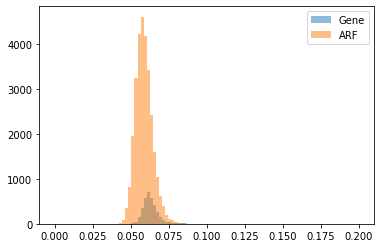

In [57]:
bins = np.linspace(0, 0.2, 100)
plt.hist(scores_GENE, bins, alpha=0.5, label="Gene")
plt.hist(scores_ARF, bins, alpha=0.5, label="ARF")
plt.legend(loc='upper right')
plt.show()

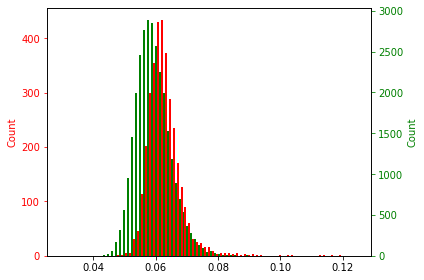

In [99]:
#https://stackoverflow.com/questions/6871201/plot-two-histograms-at-the-same-time-with-matplotlib
#sets up the axis and gets histogram data
colors = ["red", "green"]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.hist([scores_GENE, scores_ARF], color=colors)
n, bins, patches = ax1.hist([scores_GENE,scores_ARF], bins=75, range=[0.03,0.125])
ax1.cla() #clear the axis

#plots the histogram data
width = (bins[1] - bins[0]) * .5
bins_shifted = bins + width
ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

#finishes the plot
ax1.set_ylabel("Count", color=colors[0])
ax2.set_ylabel("Count", color=colors[1])
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
plt.tight_layout()
plt.show()

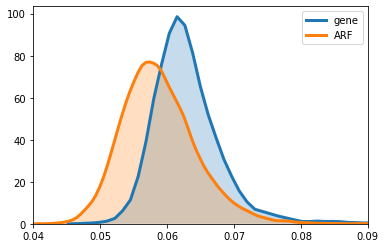

In [101]:
import seaborn as sns
sns.distplot(scores_GENE, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
             label = 'gene')
sns.distplot(scores_ARF, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
             label = 'ARF')
plt.xlim([0.04,0.09])
plt.show()